# Scraping code

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

name = input('Enter the filename here: ')
constant_value1 = int(input('Enter the Loc_ID: '))
constant_value2 = int(input('Enter the Lang_ID: '))

# Target URL
target_url = input('Enter url here: ')

driver = webdriver.Chrome()

# List to store job data
job_list = []

# Open the target URL
driver.get(target_url)

# Maximize the browser window
driver.maximize_window()

# Wait for the job listing container to load
try:
    scrolling_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='MainCol']"))
    )
    # Scroll to the bottom of the job listing container
    driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrolling_element)
except Exception as e:
    print(f"Error while scrolling: {e}")

# Wait for the "Show more jobs" button and click it
try:
    load_more_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[@data-test='load-more']"))
    )
    load_more_button.click()
    time.sleep(3)  # Wait for new content to load after clicking
except Exception as e:
    print(f"Error while clicking 'Show more jobs' button: {e}")

# Get the page source after scrolling and clicking
page_source = driver.page_source

# Close the browser
driver.quit()

# Parse the page with BeautifulSoup
soup = BeautifulSoup(page_source, 'html.parser')

# Find the job listings container
all_jobs_container = soup.find("ul", {"class": "JobsList_jobsList__lqjTr"})

# Check if the container was found
if all_jobs_container:
    # Find all job listing elements
    all_jobs = all_jobs_container.find_all("li")
    
    # Loop through each job element and extract data
    for job in all_jobs:
        job_data = {}

        # Extract company name
        company_name = job.find("div", {"class": "EmployerProfile_profileContainer__VjVBX"}).text if job.find("div", {"class": "EmployerProfile_profileContainer__VjVBX"}) else None
        if company_name and len(company_name) > 3:
            # Extract the last part of the company name, typically the last 3 characters
            last_part = company_name[-3:]
            
            try:
                # Try to convert the last part to a float
                ranking = float(last_part)
                # If successful, remove the last part from the company name and set the Ranking
                job_data["Company"] = company_name[:-3]
                job_data["Rating"] = ranking
            except ValueError:
                # If conversion to float fails, keep the original company name and leave Ranking empty
                job_data["Company"] = company_name
                job_data["Rating"] = None
        else:
            job_data["Company"] = company_name
            job_data["Rating"] = None

        # Extract job title
        job_data["Job Name"] = job.find("a", {"class": "JobCard_jobTitle___7I6y"}).text if job.find("a", {"class": "JobCard_jobTitle___7I6y"}) else None

        # Extract location
        job_data["Location"] = job.find("div", {"class": "JobCard_location__rCz3x"}).text if job.find("div", {"class": "JobCard_location__rCz3x"}) else None

        # Extract salary
        job_data["Salary"] = job.find("div", {"class": "JobCard_salaryEstimate__arV5J"}).text if job.find("div", {"class": "JobCard_salaryEstimate__arV5J"}) else None

        # Append the job data to the list
        job_list.append(job_data)

# Convert the list of jobs to a DataFrame and add the new column
df = pd.DataFrame(job_list)
# Drop rows where all elements are NaN (empty)
df.dropna(how='all', inplace=True)
df["Loc_ID"] = constant_value1  # Add the new column with the constant value
df["Lang_ID"] = constant_value2

# Save the DataFrame as a CSV file
df.to_csv(f'{name}.csv', index=False, encoding='utf-8')

print(f"Data saved to {name}.csv")



# Appending csv files

In [ ]:
import pandas as pd
import os

# Base folder containing the subfolders with CSV files
base_folder_path = r'C:\Users\3body\Datasets'

# List to hold dataframes
dataframes = []

# Walk through all subdirectories and files
for root, dirs, files in os.walk(base_folder_path):
    for filename in files:
        if filename.endswith('.csv'):
            file_path = os.path.join(root, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)

# Concatenate all dataframes into a single dataframe
appended_df = pd.concat(dataframes, ignore_index=True)

#Dropping any duplicates
appended_df.drop_duplicates(inplace=True)

# Optionally, save the resulting dataframe to a new CSV file
appended_df.to_csv('Dataset.csv', index=False)


In [ ]:
print(appended_df.duplicated().sum())

# Extracting only numbers and units from Salary

In [15]:
import re
import pandas as pd

# Load the 'Dataset' sheet into a DataFrame
dataset_df = pd.read_csv(r'C:\Users\3body\Dataset.csv')

# Define the function to handle 'Per Hour' condition and 'M' multiplier
def extract_salary_format_with_condition(salary_text):
    # Regex pattern to match numbers (with optional 'K' or 'M')
    pattern = r'(\d+\.?\d*)([KM]?)'
    
    # Convert salary_text to string for processing
    salary_text = str(salary_text)
    
    # Check if 'Per Hour' is in the salary text
    is_per_hour = 'Per Hour' in salary_text
    
    # Find all matches in the salary text (numbers with optional 'K' or 'M')
    matches = re.findall(pattern, salary_text)
    
    formatted_matches = []
    salary_values = []
    
    for match in matches:
        number, unit = match
        
        if is_per_hour:
            formatted_matches.append(f"{number}/hr")
            salary_values.append(float(number))  # Convert to float for calculations
        elif unit == 'M':
            # Convert the match to a float and multiply by 1000
            formatted_matches.append(f"{float(number) * 1000}K")
            salary_values.append(float(number) * 1000)
        elif unit == 'K':
            # Keep the number as it is for 'K'
            formatted_matches.append(f"{number}K")
            salary_values.append(float(number))
        else:
            # If no 'K' or 'M', keep the number as is
            formatted_matches.append(number)
            salary_values.append(float(number))
    
    # Join formatted matches into a single string for Formatted Salary
    formatted_salary = ", ".join(formatted_matches)
    
    # Return both the formatted salary, the list of numeric values, and the is_per_hour flag
    return formatted_salary, salary_values, is_per_hour

# Apply the function to the Salary column
dataset_df[['Formatted Salary', 'Salary Values', 'Is Per Hour']] = dataset_df['Salary'].apply(lambda x: pd.Series(extract_salary_format_with_condition(x)))

# Define a function to calculate the average salary and add 'K' or '/hr' if applicable
def calculate_average_salary(row):
    salary_values = row['Salary Values']
    is_per_hour = row['Is Per Hour']
    
    if salary_values:  # Check if the list is not empty
        avg_salary = sum(salary_values) / len(salary_values)
        # Check if the salary is per hour
        if is_per_hour:
            return f"{avg_salary}/hr"
        else:
            return f"{int(avg_salary)}K"
    return None

# Apply the average calculation function to the DataFrame
dataset_df['Average Salary'] = dataset_df.apply(calculate_average_salary, axis=1)

# Drop the Salary Values and Is Per Hour columns as they are no longer needed
dataset_df.drop(columns=['Salary Values', 'Is Per Hour'], inplace=True)

# Save the updated DataFrame to a new CSV file
output_csv_path = "updated_dataset_with_averages.csv"
dataset_df.to_csv(output_csv_path, index=False)

print(f"Updated dataset saved to {output_csv_path}")


Updated dataset saved to updated_dataset_with_averages.csv


# Converting per hour to per year

In [19]:
import pandas as pd
import re

# Load the dataset from the CSV file
dataset_df = pd.read_csv(r'C:\Users\3body\updated_dataset_with_averages.csv')

# Assuming the dataset already has the 'Average Salary' column as mentioned earlier
# Initialize a new list to store the final average salaries
final_average_salaries = []

# Iterate through each row in the DataFrame
for index, row in dataset_df.iterrows():
    average_salary = str(row['Average Salary'])
    
    if '/hr' in average_salary:
        # Extract the numeric part and multiply by 2.1
        numeric_value = float(re.findall(r'(\d+\.?\d*)', average_salary)[0])
        final_salary = numeric_value * 2.100
        final_average_salaries.append(f"{int(final_salary)}K")
    else:
        # For non '/hr' values, just forward the existing 'K' values
        final_average_salaries.append(average_salary)

# Add the final average salaries as a new column to the DataFrame
dataset_df['Final Average Salary'] = final_average_salaries

# Save the updated DataFrame to a new CSV file
output_csv_path = "updated_dataset_with_final_averages.csv"
dataset_df.to_csv(output_csv_path, index=False)

print(f"Updated dataset saved to {output_csv_path}")


Updated dataset saved to updated_dataset_with_final_averages.csv


# Detecting Outliers

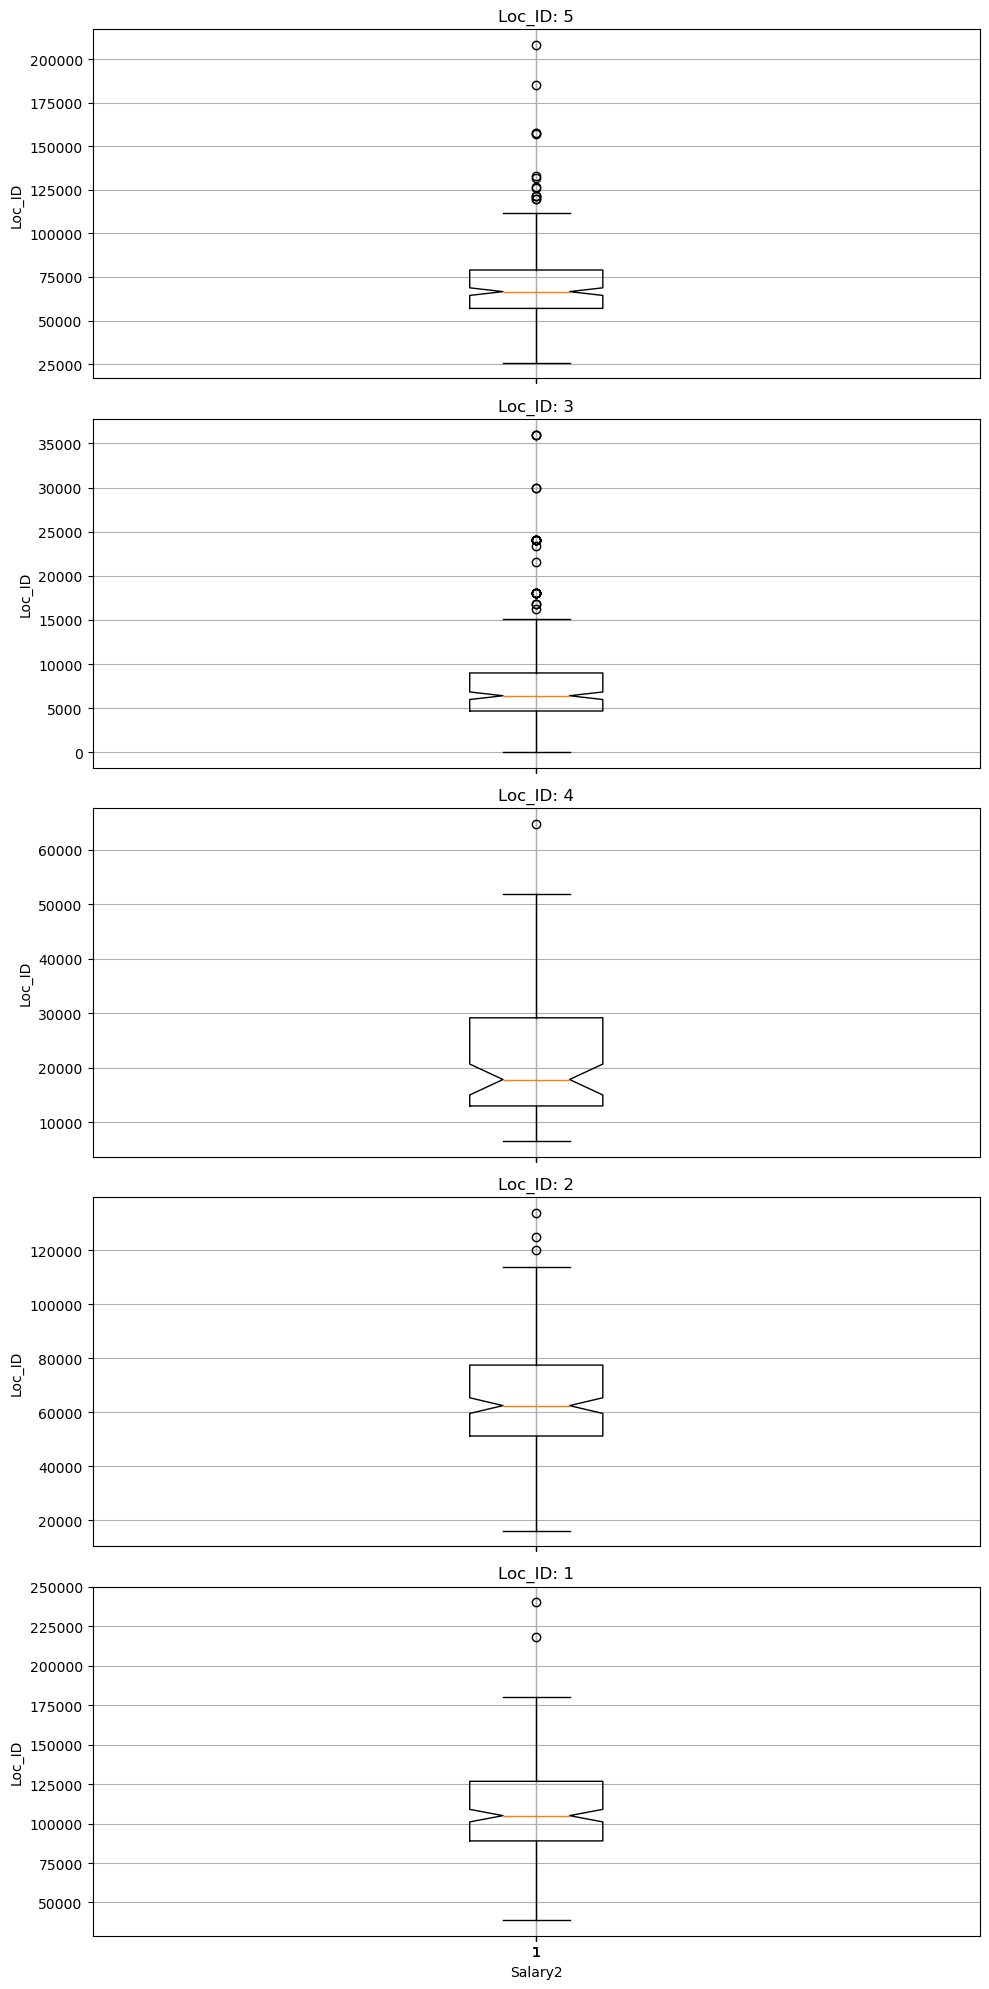

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from the CSV file
file_path = r'C:\Users\3body\updated_dataset_with_final_averages.csv'
dataset_df = pd.read_csv(file_path)

# Remove rows where 'Salary' column is 0
dataset_df = dataset_df[dataset_df['Salary2'] != 0]

# Convert 'Salary' to numeric values (assuming it's already numeric, if not, we'd need to convert it)
dataset_df['Salary2'] = pd.to_numeric(dataset_df['Salary2'], errors='coerce')

# Get unique Loc_IDs to create separate subplots
loc_ids = dataset_df['Loc_ID'].unique()

# Create subplots
fig, axes = plt.subplots(len(loc_ids), 1, figsize=(10, len(loc_ids) * 4), sharex=True)

# Plotting dot plots for each Loc_ID using 'Salary' column
for ax, loc_id in zip(axes, loc_ids):
    loc_data = dataset_df[dataset_df['Loc_ID'] == loc_id]
    ax.boxplot(loc_data['Salary2'], [loc_id] * len(loc_data), 'o')
    ax.set_title(f'Loc_ID: {loc_id}')
    ax.set_ylabel('Loc_ID')
    ax.grid(True)

# Set x-label for the bottom plot
axes[-1].set_xlabel('Salary2')

# Adjust layout
plt.tight_layout()
plt.show()


## observing outliers

In [89]:
import pandas as pd

# Load the dataset from the CSV file
file_path = r'C:\Users\3body\updated_dataset_with_final_averages.csv'
dataset_df = pd.read_csv(file_path)

# Remove rows where 'Salary' column is 0
dataset_df = dataset_df[dataset_df['Salary2'] != 0]

# Initialize a list to store outliers for each Loc_ID
outliers_list = []

# Get unique Loc_IDs to iterate over
loc_ids = dataset_df['Loc_ID'].unique()

# Loop through each Loc_ID and detect outliers in the Salary column
for loc_id in loc_ids:
    loc_data = dataset_df[dataset_df['Loc_ID'] == loc_id]
    
    # Calculate the IQR for the current Loc_ID
    Q1 = loc_data['Salary2'].quantile(0.25)
    Q3 = loc_data['Salary2'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Print the bounds for the current Loc_ID
    print(f"Loc_ID: {loc_id}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    
    # Detect outliers for the current Loc_ID
    loc_outliers = loc_data[(loc_data['Salary2'] < lower_bound) | (loc_data['Salary2'] > upper_bound)]
    
    # Append the outliers to the list
    outliers_list.append(loc_outliers)

# Concatenate all the outliers into a single DataFrame
all_outliers_df = pd.concat(outliers_list)

# Ask the user for the Loc_ID they want to display
user_loc_id = input("Enter the Loc_ID you want to display: ")

# Convert input to the appropriate type (e.g., integer or string) if5 necessary
# Assuming Loc_ID is an integer in your dataset
try:
    user_loc_id = int(user_loc_id)
except ValueError:
    pass  # If Loc_ID is a string, leave it as is

# Filter the outliers for the selected Loc_ID
filtered_outliers = all_outliers_df[all_outliers_df['Loc_ID'] == user_loc_id]

# Select and print the relevant columns: Loc_ID, Lang_ID, and Salary for the selected Loc_ID
outliers_info = filtered_outliers[['Loc_ID', 'Lang_ID', 'Salary2']]

# Display the filtered outliers
if not outliers_info.empty:
    print(outliers_info)
else:
    print(f"No outliers found for Loc_ID: {user_loc_id}")


Loc_ID: 5, Lower Bound: 23957.5, Upper Bound: 112017.5
Loc_ID: 3, Lower Bound: -1770.0, Upper Bound: 15462.0
Loc_ID: 4, Lower Bound: -11340.0, Upper Bound: 53460.0
Loc_ID: 2, Lower Bound: 11875.0, Upper Bound: 116875.0
Loc_ID: 1, Lower Bound: 32375.0, Upper Bound: 183375.0


Enter the Loc_ID you want to display:  5


     Loc_ID  Lang_ID  Salary2
7         5        2   131720
154       5        5   157620
172       5        5   156880
178       5        4   207940
185       5        4   121360
195       5        4   157620
196       5        4   119880
197       5        4   185000
199       5        4   121360
205       5        4   121360
207       5        4   119880
213       5        4   125800
227       5        4   126540
236       5        4   133200


## labeling outliers

In [108]:
import pandas as pd

# Load the dataset from the CSV file
file_path = r'C:\Users\3body\updated_dataset_with_final_averages.csv'
dataset_df = pd.read_csv(file_path)

# Initialize the 'outliers' column with default value 'within'
dataset_df['outliers'] = 'within'

# Get unique Loc_IDs to iterate over
loc_ids = dataset_df['Loc_ID'].unique()

# Loop through each Loc_ID and detect outliers in the Salary2 column, skipping values with 0
for loc_id in loc_ids:
    # Filter out rows with Salary2 == 0 for outlier detection but keep them in the DataFrame
    loc_data = dataset_df[(dataset_df['Loc_ID'] == loc_id) & (dataset_df['Salary2'] != 0)]
    
    # Calculate the IQR for the current Loc_ID
    Q1 = loc_data['Salary2'].quantile(0.25)
    Q3 = loc_data['Salary2'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the bounds for outliers
    upper_bound = Q3 + 1.5 * IQR
    
    # Update the 'outliers' column for rows where Salary2 is above the upper bound, skipping rows where Salary2 is 0
    dataset_df.loc[(dataset_df['Loc_ID'] == loc_id) & (dataset_df['Salary2'] > upper_bound), 'outliers'] = 'outlier'

# Save the updated DataFrame to a new CSV file
output_file_path = r'C:\Users\3body\updated_dataset_with_outliers.csv'
dataset_df.to_csv(output_file_path, index=False)

print("Outliers column added and saved to:", output_file_path)



Outliers column added and saved to: C:\Users\3body\updated_dataset_with_outliers.csv


## Replacing 0 values within Q1 and Q3 according to each Loc_ID

In [112]:
import pandas as pd
import numpy as np

# Load the dataset from the CSV file
file_path = r'C:\Users\3body\updated_dataset_with_outliers.csv'
dataset_df = pd.read_csv(file_path)

# Get unique Loc_IDs to iterate over
loc_ids = dataset_df['Loc_ID'].unique()

# Function to round to 1 significant figure
def round_to_1_sf(x):
    return np.round(x, -int(np.floor(np.log10(abs(x)))))

# Loop through each Loc_ID to calculate Q1 and Q3 and replace 0 values
for loc_id in loc_ids:
    # Filter the data for the current Loc_ID, skipping rows with 0 Salary2 values
    loc_data = dataset_df[(dataset_df['Loc_ID'] == loc_id) & (dataset_df['Salary2'] != 0)]
    
    # Calculate Q1 and Q3 for the current Loc_ID
    Q1 = loc_data['Salary2'].quantile(0.25)
    Q3 = loc_data['Salary2'].quantile(0.75)
    
    # Round Q1 and Q3 to 1 significant figure
    Q1_rounded = round_to_1_sf(Q1)
    Q3_rounded = round_to_1_sf(Q3)
    
    # Print the calculated and rounded Q1 and Q3 for verification
    print(f"Loc_ID: {loc_id}, Q1: {Q1_rounded}, Q3: {Q3_rounded}")
    
    # Replace 0 values in the Salary2 column for the current Loc_ID with random values between Q1 and Q3 (rounded)
    dataset_df.loc[(dataset_df['Loc_ID'] == loc_id) & (dataset_df['Salary2'] == 0), 'Salary2'] = np.random.uniform(Q1_rounded, Q3_rounded, size=len(dataset_df[(dataset_df['Loc_ID'] == loc_id) & (dataset_df['Salary2'] == 0)]))

# Round the entire 'Salary2' column to 1 significant figure before saving
dataset_df['Salary2'] = dataset_df['Salary2'].apply(round_to_1_sf)

# Save the updated DataFrame to a new CSV file
output_file_path = r'C:\Users\3body\updated_dataset_with_replaced_salaries.csv'
dataset_df.to_csv(output_file_path, index=False)

print("0 values replaced and saved to:", output_file_path)


Loc_ID: 5, Q1: 60000.0, Q3: 80000.0
Loc_ID: 3, Q1: 5000.0, Q3: 9000.0
Loc_ID: 4, Q1: 10000.0, Q3: 30000.0
Loc_ID: 2, Q1: 50000.0, Q3: 80000.0
Loc_ID: 1, Q1: 90000.0, Q3: 100000.0


C:\Users\3body\AppData\Local\Temp\ipykernel_24152\267213180.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[67519.66690941 64947.46168009 64189.46101316 76891.03396064
 70516.5834807  75410.14273412 72681.5118425  64313.11539586
 76034.16415879 70574.50640113 73493.05421068 62133.27242168
 73307.37182078 64329.68994118 66803.69575667 74626.73007369
 78367.26823033 71223.52224987 69880.58483334 62358.75219124
 62062.65649549 76885.05378673 74113.81479065 72014.81205552
 78585.88297676 71613.37928941 73589.8475327  73948.10627131
 78585.07109887 75869.94962704 69079.75943475 73130.51876374
 72019.76006087 63797.70861864 69093.59833988 62195.55104945
 79382.19282713 71777.06494974 62525.52369701 75257.9164672
 67625.98039781 76836.600272   63842.90269119 74097.40781426
 69523.39712662 73941.16774307 71608.92475187]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\3body\\updated_dataset_with_replaced_salaries.csv'

## to sql

In [4]:
import pandas as pd
import os

# Load your DataFrames from the Excel file
file_path = r'C:\Users\3body\OneDrive\Desktop\Final dataset.xlsx'
excel_file = pd.ExcelFile(file_path)

# Load the sheets into DataFrames
power_query_df = pd.read_excel(file_path, sheet_name='power query')
location_df = pd.read_excel(file_path, sheet_name='Location')
languages_df = pd.read_excel(file_path, sheet_name='Languages')

# Function to create SQL table and insert data
def generate_sql(df, table_name, file):
    with open(file, 'a') as f:
        # Create table SQL
        columns = df.columns
        create_table_sql = f"CREATE TABLE IF NOT EXISTS {table_name} (\n"
        create_table_sql += ',\n'.join([f"    {col} VARCHAR(255)" for col in columns])
        create_table_sql += "\n);\n\n"
        f.write(create_table_sql)
        
        # Insert data SQL
        for index, row in df.iterrows():
            # Use traditional string formatting to avoid issues with f-strings
            values = ', '.join(["'{}'".format(str(value).replace('\'', '\'\''))
                                if pd.notnull(value) else 'NULL' for value in row])
            insert_sql = "INSERT INTO {} ({}) VALUES ({});\n".format(
                table_name,
                ', '.join(columns),
                values
            )
            f.write(insert_sql)
        f.write("\n")

# Generate SQL file
sql_file = 'database_script.sql'

# Clear file if exists
if os.path.exists(sql_file):
    os.remove(sql_file)

# Generate SQL statements for each DataFrame
generate_sql(power_query_df, 'power_query', sql_file)
generate_sql(location_df, 'location', sql_file)
generate_sql(languages_df, 'languages', sql_file)

print(f"SQL file created: {sql_file}")



UnicodeEncodeError: 'charmap' codec can't encode character '\x81' in position 187: character maps to <undefined>